In [72]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp")

S = 128

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * B[k, j])

    return [C]

mmul = tf.program(matmul)

TensorProgram:
  Kernel count: 2
  Intermediate buffers: 5
  Lines of generated code: 114
  IR size: 67



In [73]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Bnp @ Anp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[29.936089 26.737207 33.51077  ... 27.484797 31.641926 31.324999]
 [32.65498  31.37996  36.287716 ... 31.070284 35.581604 32.5257  ]
 [33.71148  28.926386 35.500217 ... 30.563011 35.61751  32.948418]
 ...
 [30.562416 26.705427 32.471886 ... 29.58205  29.85084  30.56807 ]
 [32.98047  30.708523 36.275513 ... 31.628061 35.70277  35.06326 ]
 [29.487415 25.632877 32.26333  ... 28.827387 30.425333 29.426573]]
[[29.93608  26.737217 33.510773 ... 27.484793 31.641928 31.325   ]
 [32.654972 31.37996  36.28772  ... 31.070278 35.581604 32.52569 ]
 [33.71148  28.92639  35.500206 ... 30.563007 35.61751  32.94842 ]
 ...
 [30.562408 26.705416 32.47188  ... 29.582054 29.850836 30.56806 ]
 [32.98048  30.708527 36.275524 ... 31.628061 35.702763 35.06326 ]
 [29.487427 25.632875 32.26333  ... 28.827381 30.42534  29.426575]]
[[ 7.6293945e-06 -9.5367432e-06 -3.8146973e-06 ...  3.8146973e-06
  -1.9073486e-06 -1.9073486e-06]
 [ 7.6293945e-06  0.0000000e+00 -3.8146973e-06 ...  5.7220459e-06
   0.0000000e+00  1

In [74]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

# Performance test
t0 = time.time()
for i in range(50):
    C, = mmul(A, B)
t1 = time.time()

tf_time = t1 - t0
print("TensorFrost: ", t1 - t0)

t0 = time.time()
for i in range(50):
    Cnp2 = Bnp @ Anp
t1 = time.time()

np_time = t1 - t0
print("Numpy: ", t1 - t0)

print("TF/NP: ", tf_time / np_time)

TensorFrost:  0.13100051879882812
Numpy:  0.00299835205078125
TF/NP:  43.69083969465649


In [ ]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    t0 = time.time()
    for i in range(200):
        C, = mmul(A, B)
    t1 = time.time()

    tf_time = t1 - t0

    t0 = time.time()
    for i in range(200):
        Cnp2 = Bnp @ Anp
    t1 = time.time()

    np_time = t1 - t0

    return tf_time, np_time

sizes = [2**i for i in range(5, 11)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

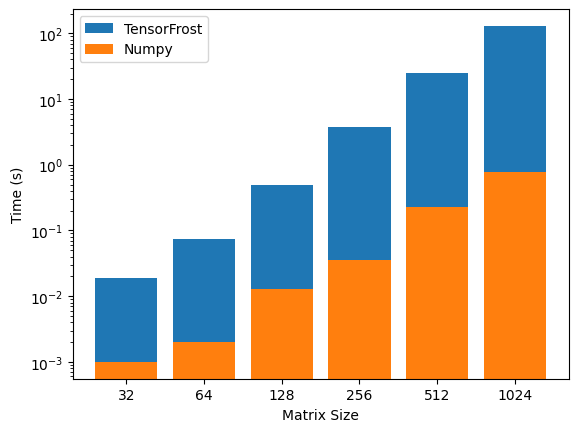

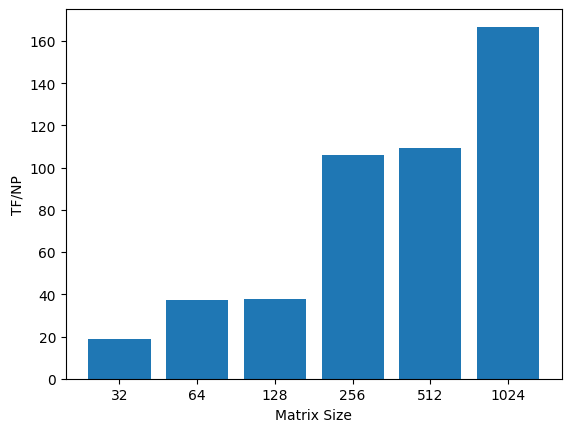

[0.019000768661499023, 0.07500028610229492, 0.4929993152618408, 3.71099853515625, 25.303001403808594, 129.59099817276]
[0.00099945068359375, 0.001999378204345703, 0.01300048828125, 0.03500032424926758, 0.23099994659423828, 0.777001142501831]


In [83]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)